In [21]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [22]:
class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
        a=1.,
    ):
    
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N
        self.a = a

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = self.a  * (- self.derivative_operator**2 - self.derivative_operator**4)
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin =  self.a * (- 0.5 * u**2 )
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = self.a * (- 0.5 * u_stage_1**2)
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [56]:
DOMAIN_SIZE = 100.
N_DOF = 200
DT = 0.00001

# Initial condition
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)
u_0 = jnp.sin(2 * jnp.pi * mesh / DOMAIN_SIZE)

ks_stepper = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
    a = 100
)
ks_stepper = jax.jit(ks_stepper)

def scan_fn(u, _):
    u_next = ks_stepper(u)
    return u_next, u_next

# Time step
final_state, trj = jax.lax.scan(
    scan_fn,
    u_0,
    None,
    length=100_000,
)

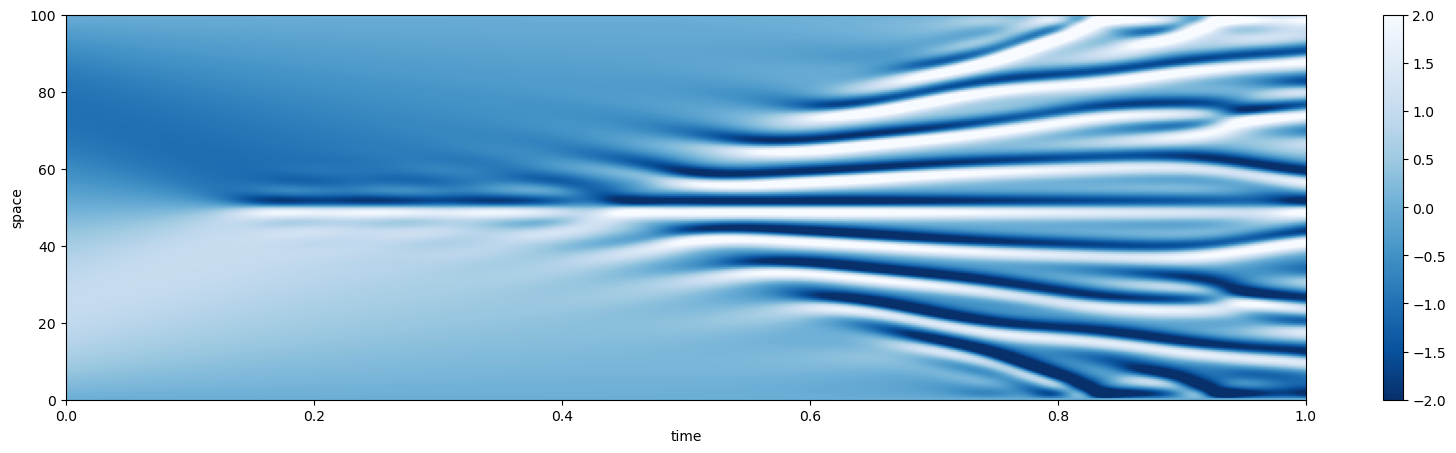

In [57]:
fig = plt.figure(figsize=(20, 5),)
plt.imshow(
    trj.T,
    cmap='Blues_r',
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, DOMAIN_SIZE),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")
plt.show()

In [25]:
DOMAIN_SIZE = 100.0
N_DOF = 200
DT = 0.001

# Initial condition
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)
u_0 = jnp.sin(2 * jnp.pi * mesh / DOMAIN_SIZE)

ks_stepper = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
    a = 1.
)
ks_stepper = jax.jit(ks_stepper)

def scan_fn(u, _):
    u_next = ks_stepper(u)
    return u_next, u_next

# Time step
final_state, trj = jax.lax.scan(
    scan_fn,
    u_0,
    None,
    length=200_000,
)

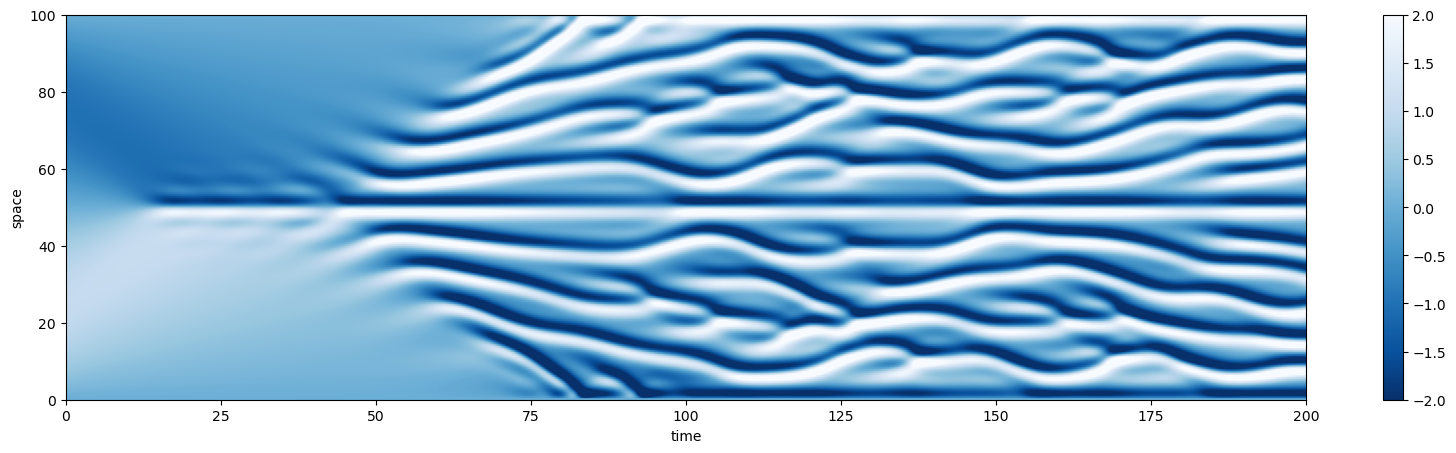

In [26]:
fig = plt.figure(figsize=(20, 5),)
plt.imshow(
    trj.T,
    cmap='Blues_r',
    aspect="auto",
    origin="lower",
    extent=(0, trj.shape[0] * DT, 0, DOMAIN_SIZE),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")
plt.show()